<a href="https://colab.research.google.com/github/vignejs/cover-song-identification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Convolutional Neural Network for Cover song identification

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons==0.9.1

In [3]:
import itertools
import os
import random
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from scipy import interpolate
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, Input, Lambda, Layer,
                                     MaxPooling2D, ReLU)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.python.framework.ops import Tensor

warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.1.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


### Load data

In [4]:
feature_type = "crema"
spect_len = 500

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    root = Path("/content/drive/My Drive/cosoid")
else:
    root = Path.cwd()

traindf = pd.HDFStore(root / 'datasets' / 'trainset.h5').select(feature_type)
valdf = pd.HDFStore(root / 'datasets' / 'valset.h5').select(feature_type)

In [5]:
traindf = traindf.groupby(by='work_id').filter(lambda x: len(x) == 13 * 12)

In [6]:
train = traindf.values.reshape(1000, 13, 12, 500)
val = valdf.values.reshape(5000, 2, 12, 500)

In [7]:
def gen_indexes(w_shape, p_shape):
    """generates combination of pair of indices for siamese input
        w_shape: no of works
        p_shape: no of performances
    """
    indexes = list()
    
    p = list(itertools.permutations(range(p_shape), 2))
    
    r = range(w_shape)
    for i in range(w_shape):
        np.random.seed(0)
        rand = np.random.choice([x for x in r if x != i], size=len(p), replace=False)
        for j, (x, y) in enumerate(p):
            indexes.append([(i,x), (i,y)])
            indexes.append([(i, x), (rand[j], y)])
            
    return indexes

In [8]:
indexes_train = gen_indexes(1000, 13)
indexes_val = gen_indexes(5000, 2)

### Using keras.seqential

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    '''Generates data for Keras'''
    def __init__(self, data, indexes, batch_size=100, dim=(12, 1000), n_channels=1, shuffle=False, train=False):
        '''Initialization'''
        self.dim = dim
        self.data = data
        self.train = train
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.indexes = indexes    
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.indexes) / self.batch_size / 4)) 

    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # return data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        if self.shuffle:
            np.random.shuffle(self.indexes)   
    
    def __data_augmentor(self, aug):

        hg = aug.shape[0]
        wd = aug.shape[1]
        
        # time shift
        rng = int(np.random.normal() * wd)
        aug = np.roll(aug, rng, axis=1)

        # chroma transposition
        rng = int(np.random.normal() * hg)
        aug = np.roll(aug, rng, axis=0)
        
        times = np.arange(0, wd)
        func = interpolate.interp1d(times, aug, kind='nearest', fill_value='extrapolate')
            
        # time stretch
        if np.random.uniform() < 0.3:
            rng = 1 + np.random.normal()  # random number to determine the factor of time stretching

            if 0.7 <= rng <= 1.3:
                times = np.linspace(0, wd - 1, int(wd * rng))
                aug = func(times)  # applying time stretching
                
        # time warping 
        if np.random.uniform() < 0.3:
            rng = np.random.uniform()  # random number to determine which operation to apply for time warping

            if rng < 0.3:  # silence
                # each frame has a probability of 0.1 to be silenced
                silence_idxs = np.random.choice([False, True], size=times.size, p=[.9, .1])
                aug[:, silence_idxs] = np.zeros((hg, 1))

            elif rng < 0.7:  # duplicate
                # each frame has a probability of 0.15 to be duplicated
                duplicate_idxs = np.random.choice([False, True], size=times.size, p=[.85, .15])
                times = np.sort(np.concatenate((times, times[duplicate_idxs])))
                aug = func(times)

            else:  # remove
                # each frame has a probability of 0.1 to be removed
                remaining_idxs = np.random.choice([False, True], size=times.size, p=[.1, .9])
                times = times[remaining_idxs]
                aug = func(times)

        
        if aug.shape[1] > wd:
            aug = aug[:, :wd]
        else:
            aug = np.pad(aug, ((0, 0), (0, wd - aug.shape[1])), 'wrap')   

        return aug
    
    def _data_augmentor(self, a):
        if self.train:
            return self.__data_augmentor(a)
        else:
            return a   

    def __data_generation(self, indexes):
        '''Generates data containing batch_size samples''' # X : (n_samples, *dim, n_channels)
        # Initialization
        X1 = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        X2 = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        Y = np.empty((self.batch_size, 1), dtype=np.int)

        # Generate data
        for i, (x, y) in enumerate(indexes):
            # sample a sample
            r1 = self.data[x]
            r2 = self.data[y]

            r1 = np.tile(r1, (2, 1))[:-1]
            r2 = np.tile(r2, (2, 1))[:-1]

            # augment sample
            if np.random.uniform() < 0.5:
                r1 = self._data_augmentor(r1)
            else:
                r2 = self._data_augmentor(r2)

            # store sample
            X1[i, ] = r1.reshape(*self.dim, self.n_channels)
            X2[i, ] = r2.reshape(*self.dim, self.n_channels)

            # store label
            if x[0] == y[0]:
                Y[i, ] = [0]
            else:
                Y[i, ] = [1]     

        return [X1, X2], Y

In [10]:
# Parameters
params = {'dim': (23, spect_len),
          'batch_size': 128,
          'n_channels': 1,
          'shuffle': True}

training_generator = DataGenerator(train, indexes_train, **params, train=True)
validation_generator = DataGenerator(val, indexes_val, **params)

def tr_generator():
    multi_enqueuer = tf.keras.utils.OrderedEnqueuer(training_generator, use_multiprocessing=True, shuffle=False)
    multi_enqueuer.start(workers=4, max_queue_size=5)
    while True:
        yield next(multi_enqueuer.get())

def va_generator():
    multi_enqueuer = tf.keras.utils.OrderedEnqueuer(validation_generator, use_multiprocessing=True, shuffle=False)
    multi_enqueuer.start(workers=4, max_queue_size=5)
    while True:
        yield next(multi_enqueuer.get())


training_dataset = tr_generator()
validation_dataset = va_generator()

### Siamese Architecture

In [11]:
# Initializers
def W_init(shape, dtype=None):
    """Initialize weights"""
    values = np.random.normal(loc=0, scale=1e-2, size=shape)
    return K.variable(values, dtype=dtype)

def W_init_dense(shape, dtype=None):
    """Initialize weights"""
    values = np.random.normal(loc=0, scale=2e-1, size=shape)
    return K.variable(values, dtype=dtype)
 
def b_init(shape, dtype=None):
    """Initialize bias"""
    values = np.random.normal(loc=0.5, scale=1e-2, size=shape)
    return K.variable(values, dtype=dtype)

In [12]:
def create_base_network(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (12, 50), input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(12, 1)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (1, 5), dilation_rate=(1, 1), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(Conv2D(64, (1, 5), dilation_rate=(1, 20), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(ReLU())
    model.add(BatchNormalization())

    model.add(Conv2D(32, (1, 5), dilation_rate=(1, 1), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(Conv2D(64, (1, 5), dilation_rate=(1, 13), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(ReLU())
    model.add(BatchNormalization())

    model.add(Conv2D(32, (1, 5), dilation_rate=(1, 1), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(Conv2D(64, (1, 5), dilation_rate=(1, 7), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(ReLU())
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='sigmoid', kernel_initializer=W_init_dense, bias_initializer=b_init))
    print(model.summary())

    return model

def create_twin():
    input_shape = (23, spect_len, 1)
    original_input = Input(shape=input_shape, name="input_1")
    cover_input = Input(shape=input_shape, name="input_2")
    model = create_base_network(input_shape)
    original_model = model(original_input)
    cover_model = model(cover_input)

    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([original_model, cover_model])

    output = Dense(1, activation='sigmoid')(L1_distance)

    model = Model(inputs=[original_input, cover_input], outputs=[output])

    return model

model = create_twin()
best_weights_file = "{}/weights/weights.best-{:.2e}.hdf5".format(root, model.count_params())

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
opt = tfa.optimizers.Lookahead(opt)
contrastive_loss = tfa.losses.ContrastiveLoss()

custom_objects = {"W_init": W_init,
                  "W_init_dense": W_init_dense,
                  "b_init": b_init}

# model = load_model(best_weights_file, custom_objects=custom_objects)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 12, 451, 32)       19232     
_________________________________________________________________
re_lu (ReLU)                 (None, 12, 451, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 451, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 451, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 447, 32)        5152      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 367, 64)        10304     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1, 367, 64)        0

### Training

In [13]:
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

csv_logger = CSVLogger(f"{root}/logs/training-{model.count_params():.2e}.csv", append=False)

def get_lr_callback():
    lr_start   = 0.00005
    lr_max     = 0.0001
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.95
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

lr_schedule = get_lr_callback()

callbacks = [checkpoint, lr_schedule, csv_logger]

In [ ]:
# Train model on dataset (sequence)
history = model.fit(training_dataset,
                    validation_data=validation_dataset,
                    steps_per_epoch=len(training_generator),
                    validation_steps=len(validation_generator),
                    use_multiprocessing=False,
                    workers=1,
                    verbose=1,
                    callbacks=callbacks,
                    epochs=100)

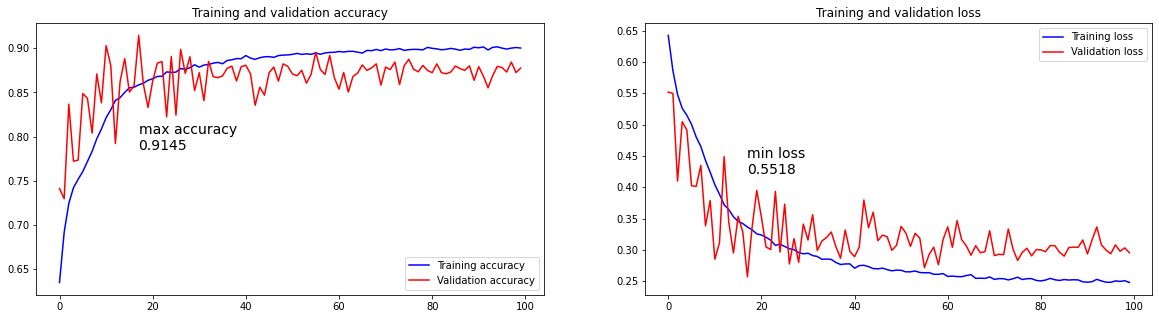

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
fig = plt.figure(figsize=(20, 5))
plt.subplot(121)
x = np.argmax( history.history['val_accuracy'] )
y = np.max( history.history['val_accuracy'] )
xdist = plt.xlim()[1] - plt.xlim()[0]
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.text(x-0.03*xdist,y-0.13*ydist,'max accuracy\n%.4f'%y,size=14)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
x = np.argmin( history.history['val_loss'] )
y = np.max( history.history['val_loss'] )
xdist = plt.xlim()[1] - plt.xlim()[0]
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.text(x-0.03*xdist,y-0.13*ydist,'min loss\n%.4f'%y,size=14)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()